In [1]:
import rebound
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
%matplotlib inline

## Initial parameters
$\mu$ = $M_2$/{$M_1$ + $M_2$}   
$M_1$ + $M_2$ = 1$M_{sun}$   
$M_1$ > $M_2$ & $M_2$>0.2$M_{sun}$   
$a_{bin}$ = 0.1 au   
$a_{p}$ = 0.5~1.5 au   
G = 1  
$T_{bin}$ = 2$\pi$  
$v_{esc}$ = $\sqrt[2]\frac{2}{a_p}$   
$m_{planet}$ = $3*10^{-6}$$M_{sun}$

In [2]:
def setupSimulation(u, e, a_p, inc):
    #Initial Condition
    m1 = 1-u
    m2 = u
    m3 = 3e-6
    p=np.pi/2
    
    #setup model
    sim = rebound.Simulation()
    sim.add(m=m1, hash='primary star')# Star A
    sim.add(m=m2, a=0.1, e=e, hash='secondary star') #Star B
    sim.add(m=m3, a=a_p, inc=inc, hash='planet') #Planet ABc
    sim.move_to_com()
    fig = rebound.OrbitPlot(sim,slices=0.8,xlim=[-5.,5],ylim=[-5.,5])# this is the initial state of orbit
    return sim

In [3]:
#Initial Condition
U = widgets.FloatSlider(
    value=0.2,
    min=0.2,
    max=0.5,
    step=0.01,
    description='mass ratio:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f'
)
E = widgets.FloatSlider(
    value=0.4,
    min=0,
    max=0.8,
    step=0.01,
    description='eccentricity:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f'
)
Inc = widgets.IntSlider(
    value=0,
    min=0,
    max=360,
    step=36,
    description='inclination:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
D = widgets.FloatSlider(
    value=1,
    min=0.5,
    max=1.5,
    step=0.01,
    description='distance', # the distance between planet and binary centre
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f'
)
display(U, E, Inc, D)

FloatSlider(value=0.2, continuous_update=False, description='mass ratio:', max=0.5, min=0.2, step=0.01)

FloatSlider(value=0.4, continuous_update=False, description='eccentricity:', max=0.8, step=0.01)

IntSlider(value=0, continuous_update=False, description='inclination:', max=360, step=36)

FloatSlider(value=1.0, continuous_update=False, description='distance', max=1.5, min=0.5, step=0.01)

0.04367902323681493
Stable
CPU times: user 28 s, sys: 182 ms, total: 28.2 s
Wall time: 27.9 s


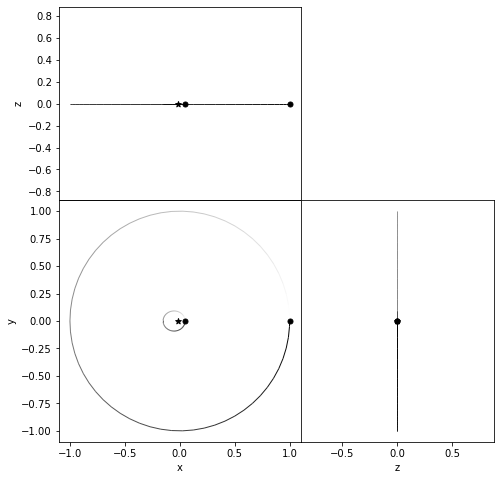

In [4]:
%%time
#Initial Condition for P-type with inclination
u = U.value
e = E.value
inc = Inc.value*np.pi/180

a_p = D.value
t = 2*np.pi*a_p*np.sqrt(a_p)#The period of a planet
v_esc2 = 2/a_p # the square of v_escape
sim = setupSimulation(u, e, a_p, inc)
print(sim.particles['secondary star'].calculate_orbit().rhill)
sim.exit_min_distance = sim.particles['secondary star'].calculate_orbit().rhill
#sim.exit_min_distance = 0.01
Noutputs = 1000*4
times = np.linspace(0, 1000*t, Noutputs)
distances = np.zeros(Noutputs)
velocity2 = np.zeros(Noutputs)#the square of velocity2
ps = sim.particles # ps is now an array of pointers. It will update as the simulation runs.
try:
        for i, time in enumerate(times):
            sim.integrate(time)
            dp = ps[1] - ps[2]
            dv = ps[2]
            distances[i] = np.sqrt(dp.x*dp.x+dp.y*dp.y+dp.z*dp.z)
            velocity2[i] =  (dv.vx*dv.vx+dv.vy*dv.vy+dv.vz*dv.vz)
        if max(velocity2) > v_esc2:
            print("Escape")
        else:
            print("Stable")
except rebound.Encounter as error:
    print("Encounter")
    

Text(55000, 0.42, 'Vesc2=2.0')

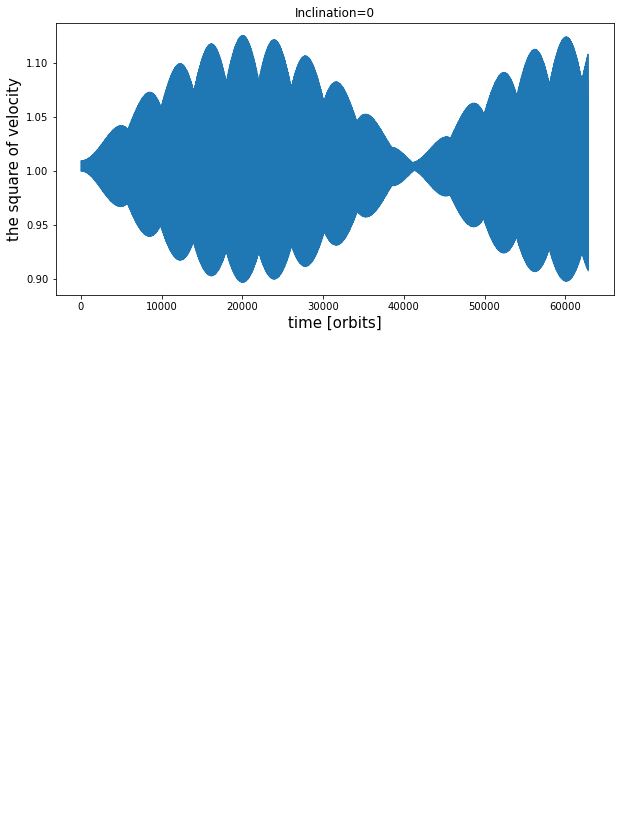

In [5]:
y=velocity2[:]
x=np.linspace(0,10000*t, Noutputs)
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(1,1,1)
ax.set_title("Inclination=%.2s"%Inc.value)
ax.set_xlabel("time [orbits]",fontsize=15)
ax.set_ylabel("the square of velocity",fontsize=15)
plt.plot(x, y, linewidth=1)
plt.annotate("Vmax2=%.4s"%max(velocity2), xy=(55000,0.40),fontsize=13)
plt.annotate("Vesc2=%.4s"%v_esc2, xy=(55000,0.42),fontsize=13)

Text(300, 1.4, 'Dmin=0.88')

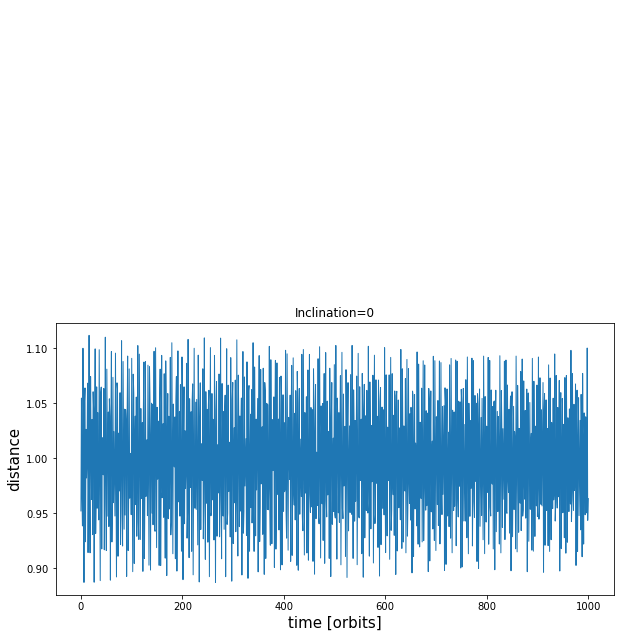

In [8]:
y=distances[:1000]
x=np.linspace(0,1000,1000)
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(1,1,1)
ax.set_title("Inclination=%.2s"%Inc.value)
ax.set_xlabel("time [orbits]",fontsize=15)
#ax.set_xlim([0,sim.t/(2.*np.pi)])
ax.set_ylabel("distance",fontsize=15)
plt.plot(x, y,linewidth=1 );
#plt.plot([0.0,500],[0.0436,0.0436], linewidth=3) # Plot our close encounter criteria;
plt.annotate("Dmin=%.4s"%min(y), xy=(300,1.4),fontsize=15)
#plt.annotate("Encounter Criteria=0.0436", xy=(300,1),fontsize=15)

Text(0, 0.5, 'y [AU]')

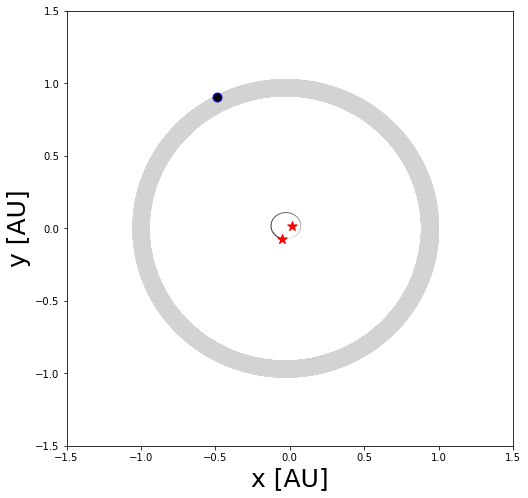

In [9]:
fig, ax = plt.subplots(figsize=(8,8))
#ax.set_title('$A stable circumbinary planetary system$',fontsize=28)
ps = sim.particles
Noutputs = 10000*10
times = np.linspace(0, 10000*t, Noutputs)
v_ratio=max(velocity2)/v_esc2

#manually set plot boundaries
lim = 1.5
ax.set_xlim([-lim, lim])
ax.set_ylim([-lim, lim])

#plot the stars and planets with separate symbols
linewidth = 1.

for star in ps[:2]:
    ax.scatter(star.x, star.y, s=100*linewidth, marker='*', facecolor='red', zorder=3)

for planet in ps[2:]:
    ax.scatter(planet.x, planet.y, color='b', s=80*linewidth, facecolor='black', zorder=3)

# Now individually plot orbit trails with appropriate orbit
from rebound.plotting import fading_line
B = ps[1] # star B
o = np.array(B.sample_orbit())
lc = fading_line(o[:,0], o[:,1], linewidth=linewidth)
ax.add_collection(lc)

planet_x = np.zeros(Noutputs)
planet_y = np.zeros(Noutputs)
for i, time in enumerate(times):
    sim.integrate(time)
    planet_x[i] = ps[2].x
    planet_y[i] = ps[2].y
lc = fading_line(planet_x, planet_y, linewidth=0.01, color='lightgray')
ax.add_collection(lc)

#plt.annotate("V2/Vesc2=%.4s"%v_ratio, xy=(3,5),fontsize=15)
#plt.annotate("e=%s"%e, xy=(3,4.6), fontsize=15, fontweight='light')
#plt.annotate("u=%s"%u, xy=(3,4.2), fontsize=15)
ax.set_xlabel("x [AU]",fontsize=25)
ax.set_ylabel("y [AU]",fontsize=25)